In [1]:
!pip install roboflow
from roboflow import Roboflow

# Connect to Roboflow and download the dataset
rf = Roboflow(api_key="ZC9YX5kSm5wFRKdnv9m2")
project = rf.workspace("demo-tlvzf").project("mp-n2wrn")
dataset = project.version(4).download("yolov9", location="/content/yolov9_data/").location


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/yolov9_data/ in yolov9:: 100%|██████████| 1212/1212 [00:00<00:00, 3618.97it/s]


In [2]:
!pip install torch torchvision matplotlib opencv-python albumentations

In [22]:
import os
import xml.etree.ElementTree as ET
from xml.dom import minidom
import cv2

def create_pascal_voc_annotation(image_path, label_path, output_dir, class_names):
    image = cv2.imread(image_path)
    h, w, c = image.shape

    # Parse YOLO annotations
    with open(label_path, 'r') as file:
        lines = file.readlines()

    annotation = ET.Element("annotation")
    folder = ET.SubElement(annotation, "folder").text = os.path.basename(os.path.dirname(image_path))
    filename = ET.SubElement(annotation, "filename").text = os.path.basename(image_path)
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(w)
    ET.SubElement(size, "height").text = str(h)
    ET.SubElement(size, "depth").text = str(c)

    for line in lines:
        class_id, x_center, y_center, box_width, box_height = map(float, line.split())
        x_min = int((x_center - box_width / 2) * w)
        y_min = int((y_center - box_height / 2) * h)
        x_max = int((x_center + box_width / 2) * w)
        y_max = int((y_center + box_height / 2) * h)

        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = class_names[int(class_id)]
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(x_min)
        ET.SubElement(bndbox, "ymin").text = str(y_min)
        ET.SubElement(bndbox, "xmax").text = str(x_max)
        ET.SubElement(bndbox, "ymax").text = str(y_max)

    # Convert to a pretty XML string
    xml_str = minidom.parseString(ET.tostring(annotation)).toprettyxml(indent="   ")
    xml_output_path = os.path.join(output_dir, os.path.basename(label_path).replace(".txt", ".xml"))

    with open(xml_output_path, "w") as xml_file:
        xml_file.write(xml_str)

# Paths
image_dir = "/content/yolov9_data/train/images"
label_dir = "/content/yolov9_data/train/labels"
output_dir = "/content/yolov9_data/train/xml_annotations"
os.makedirs(output_dir, exist_ok=True)

# Class names (update as per your dataset)
class_names = ["background", "Cardboard", "E-waste", "Fabric", "Metal", "Organic", "Paper", "Plastic"]

# Convert all YOLO annotations
for label_file in os.listdir(label_dir):
    image_path = os.path.join(image_dir, label_file.replace(".txt", ".jpg"))
    label_path = os.path.join(label_dir, label_file)
    create_pascal_voc_annotation(image_path, label_path, output_dir, class_names)


In [23]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from xml.etree import ElementTree as ET
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Custom Dataset for Pascal VOC Format
class PascalVOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, class_names=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith(".jpg")]
        self.class_names = class_names

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        boxes = []
        labels = []
        size = root.find("size")
        width = int(size.find("width").text)
        height = int(size.find("height").text)

        for obj in root.findall("object"):
            name = obj.find("name").text
            label = self.class_names.index(name) + 1
            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        return boxes, labels, width, height

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        annotation_path = os.path.join(self.annotation_dir, self.images[index].replace(".jpg", ".xml"))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        boxes, labels, width, height = self.parse_voc_xml(annotation_path)

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, class_labels=labels)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        return image, boxes, labels


# Define Transformations
transform = A.Compose(
    [
        A.Resize(300, 300),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)

# Define Collate Function
def collate_fn(batch):
    images = []
    targets = []
    for image, boxes, labels in batch:
        images.append(image)
        targets.append(
            {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
            }
        )
    return images, targets


# Dataset Paths
image_dir = "/content/yolov9_data/train/images"
annotation_dir = "/content/yolov9_data/train/xml_annotations"
class_names = ["background", "Cardboard", "E-waste", "Fabric", "Metal", "Organic", "Paper", "Plastic"]

# Initialize Dataset and DataLoader
train_dataset = PascalVOCDataset(
    image_dir=image_dir, annotation_dir=annotation_dir, transform=transform, class_names=class_names
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


# # Test the DataLoader
# for images, targets in train_loader:
#     print(f"Batch of images: {len(images)}")
#     print(f"Image shape: {images[0].shape}")
#     print(f"Targets: {targets}")
#     break


Batch of images: 16
Image shape: torch.Size([3, 300, 300])
Targets: [{'boxes': tensor([[195.0000,  64.6875, 246.5625, 194.5312],
        [115.7812,   6.0938, 166.4062,  65.1562],
        [ 45.9375,  90.4688, 118.1250, 204.8438],
        [118.5938, 173.4375, 192.1875, 293.9062]]), 'labels': tensor([5, 2, 2, 3])}, {'boxes': tensor([[202.9688,  56.2500, 264.8438, 127.0312],
        [ 43.5937,  29.0625, 147.1875, 128.4375],
        [185.6250, 172.5000, 288.2812, 239.5312],
        [ 40.3125, 195.4688, 144.3750, 274.6875],
        [275.6250, 258.7500, 300.0000, 300.0000]]), 'labels': tensor([4, 2, 5, 3, 5])}, {'boxes': tensor([[169.2188,  14.0625, 262.0312,  97.5000],
        [126.0938, 124.2188, 300.0000, 293.4375],
        [ 15.4687,  90.9375,  73.5938, 219.3750]]), 'labels': tensor([7, 1, 4])}, {'boxes': tensor([[135.0000,  55.7812, 230.1562, 131.2500],
        [147.6562, 127.5000, 295.7812, 293.9062],
        [  1.8750,  25.7812, 110.6250, 162.6562],
        [  7.5000, 181.4062, 106.875

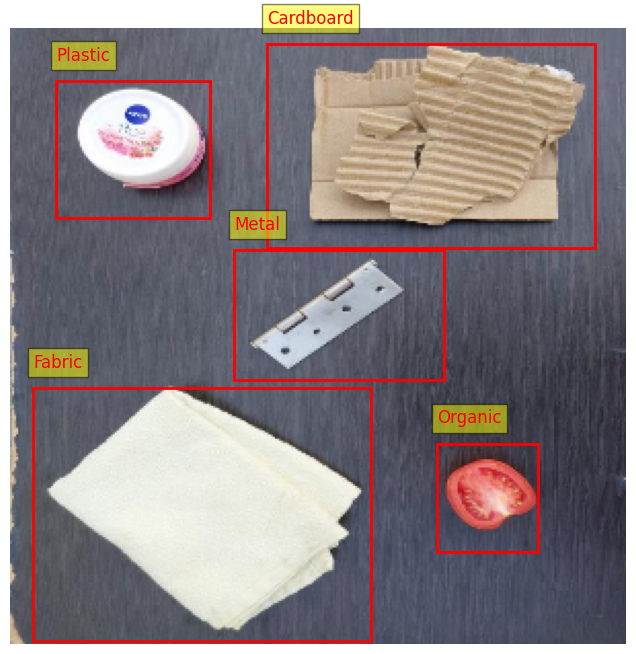

In [29]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, index):
    image, boxes, labels = dataset[index]
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    image = (image * 255).astype("uint8")

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    for box, label in zip(boxes, labels):
        if label == 0:  # Skip background
          continue
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(x_min, y_min - 10, dataset.class_names[int(label)], color='red', fontsize=12,
                 bbox=dict(facecolor='yellow', alpha=0.5))  # Ensure label is cast to int
    plt.axis("off")
    plt.show()

# Visualize a sample
visualize_sample(train_dataset, index=84)


In [25]:
import torch
import torchvision
from torchvision.models.detection import SSD300_VGG16_Weights

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load SSD model pre-trained on COCO with updated weights
weights = SSD300_VGG16_Weights.DEFAULT  # Or use COCO_V1 explicitly if needed
ssd_model = torchvision.models.detection.ssd300_vgg16(weights=weights)

# Update the classification head to match the number of classes
ssd_model.head.classification_head.num_classes = len(class_names) + 1  # 7 classes + 1 background
ssd_model = ssd_model.to(device)


In [26]:
from collections import defaultdict
import numpy as np
from torchvision.ops import box_iou
from torch.optim import AdamW

# Helper Function: Calculate mAP for a Single Class
def compute_ap(precision, recall):
    """Compute the Average Precision (AP) for a given precision-recall curve."""
    precision = np.concatenate(([0.0], precision, [0.0]))
    recall = np.concatenate(([0.0], recall, [1.0]))

    # Ensure precision is monotonically decreasing
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    # Compute the area under the precision-recall curve
    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap


# Function to Calculate mAP
def calculate_map(predictions, ground_truths, class_names, iou_threshold=0.5):
    """
    Calculate mAP for each class.

    Args:
    - predictions: List of predicted boxes, labels, scores.
    - ground_truths: List of ground-truth boxes, labels.
    - class_names: List of class names.
    - iou_threshold: IoU threshold to consider a detection correct.

    Returns:
    - class_map: Dictionary with class-wise mAP values.
    """
    class_ap = {}
    for class_idx, class_name in enumerate(class_names):
        class_preds = []
        class_gts = defaultdict(list)

        # Filter predictions and ground truths by class
        for pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels in zip(
            predictions["boxes"], predictions["labels"], predictions["scores"],
            ground_truths["boxes"], ground_truths["labels"]
        ):
            class_preds.extend(
                [
                    {"box": box, "score": score, "gt_matched": False}
                    for box, label, score in zip(pred_boxes, pred_labels, pred_scores)
                    if label == class_idx
                ]
            )
            class_gts[class_idx].extend([gt_box for gt_box, gt_label in zip(gt_boxes, gt_labels) if gt_label == class_idx])

        # Sort predictions by confidence score
        class_preds = sorted(class_preds, key=lambda x: x["score"], reverse=True)

        # Match predictions to ground truths
        true_positives = []
        false_positives = []
        gt_matched = set()
        for pred in class_preds:
            matched = False
            for gt_idx, gt_box in enumerate(class_gts[class_idx]):
                if gt_idx in gt_matched:
                    continue
                iou = box_iou(torch.tensor([pred["box"]]), torch.tensor([gt_box]))[0, 0].item()
                if iou >= iou_threshold:
                    matched = True
                    gt_matched.add(gt_idx)
                    break
            true_positives.append(matched)
            false_positives.append(not matched)

        # Compute precision and recall
        true_positives = np.cumsum(true_positives)
        false_positives = np.cumsum(false_positives)
        recall = true_positives / len(class_gts[class_idx]) if class_gts[class_idx] else np.zeros(len(true_positives))
        precision = true_positives / (true_positives + false_positives)

        # Compute AP for the class
        ap = compute_ap(precision, recall)
        class_ap[class_name] = ap

    return class_ap


# Training Loop with mAP Calculation
def train_one_epoch_with_map(model, loader, optimizer, device, class_names, iou_threshold=0.5):
    model.train()
    total_loss = 0
    predictions = {"boxes": [], "labels": [], "scores": []}
    ground_truths = {"boxes": [], "labels": []}

    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        # Evaluate predictions
        model.eval()  # Switch to evaluation mode for inference
        with torch.no_grad():
            outputs = model(images)

        for i, output in enumerate(outputs):
            predictions["boxes"].append(output["boxes"].cpu().numpy())
            predictions["labels"].append(output["labels"].cpu().numpy())
            predictions["scores"].append(output["scores"].cpu().numpy())
            ground_truths["boxes"].append(targets[i]["boxes"].cpu().numpy())
            ground_truths["labels"].append(targets[i]["labels"].cpu().numpy())

        model.train()  # Switch back to training mode

    avg_loss = total_loss / len(loader)
    class_map = calculate_map(predictions, ground_truths, class_names, iou_threshold)

    return avg_loss, class_map

optimizer = AdamW(ssd_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Full Training Loop
for epoch in range(30):
    avg_loss, class_map = train_one_epoch_with_map(ssd_model, train_loader, optimizer, device, class_names)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    for class_name, ap in class_map.items():
        print(f"  AP for {class_name}: {ap:.4f}")
    mAP = sum(class_map.values()) / len(class_names)
    print(f"  mAP: {mAP:.4f}")


Epoch 1, Loss: 4.8100
  AP for background: 0.0000
  AP for Cardboard: 0.9286
  AP for E-waste: 0.9402
  AP for Fabric: 0.8943
  AP for Metal: 0.8609
  AP for Organic: 0.8202
  AP for Paper: 0.8232
  AP for Plastic: 0.9041
  mAP: 0.7714
Epoch 2, Loss: 2.6199
  AP for background: 0.0000
  AP for Cardboard: 0.9138
  AP for E-waste: 0.9555
  AP for Fabric: 0.9418
  AP for Metal: 0.9345
  AP for Organic: 0.9032
  AP for Paper: 0.9242
  AP for Plastic: 0.9270
  mAP: 0.8125
Epoch 3, Loss: 1.9690
  AP for background: 0.0000
  AP for Cardboard: 0.9534
  AP for E-waste: 0.9678
  AP for Fabric: 0.9746
  AP for Metal: 0.9549
  AP for Organic: 0.9408
  AP for Paper: 0.9616
  AP for Plastic: 0.9649
  mAP: 0.8398
Epoch 4, Loss: 1.6686
  AP for background: 0.0000
  AP for Cardboard: 0.9724
  AP for E-waste: 0.9739
  AP for Fabric: 0.9719
  AP for Metal: 0.9681
  AP for Organic: 0.9450
  AP for Paper: 0.9641
  AP for Plastic: 0.9581
  mAP: 0.8442
Epoch 5, Loss: 1.4383
  AP for background: 0.0000
  AP f

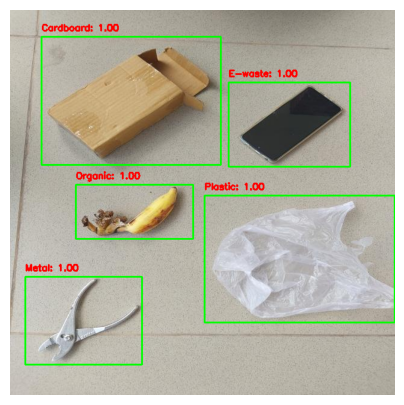

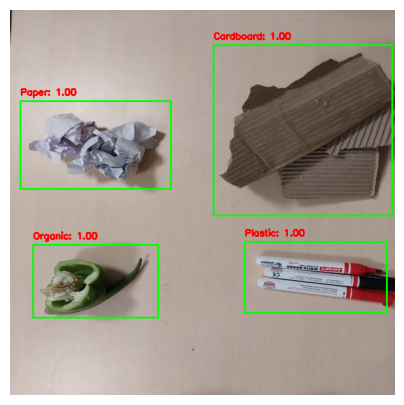

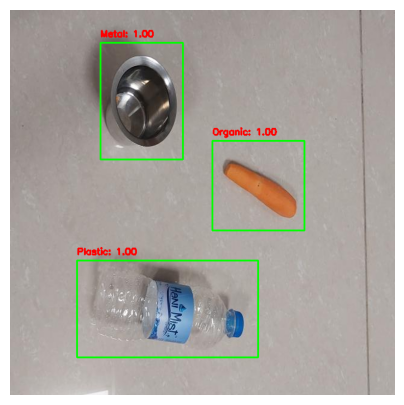

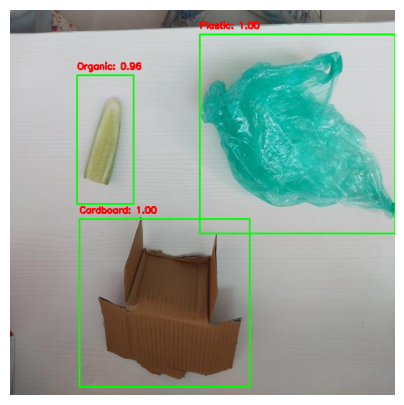

In [33]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Preprocessing Transformations
test_transform = A.Compose(
    [
        A.Resize(300, 300),  # Ensure this matches the model's expected input size
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Function to Load and Preprocess an Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image.shape[:2]
    transformed = test_transform(image=image)
    return (
        transformed["image"],  # Preprocessed tensor
        image,  # Original image (RGB)
        original_width,
        original_height,
    )

# Function to Perform Inference
def predict_and_visualize(model, image_path, class_names, device, conf_threshold=0.5):
    # Preprocess the image
    input_tensor, original_image, original_width, original_height = preprocess_image(image_path)
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Perform inference
    model.eval()
    with torch.no_grad():
        predictions = model(input_tensor)[0]

    # Postprocess predictions
    boxes = predictions["boxes"].cpu().numpy()
    labels = predictions["labels"].cpu().numpy()
    scores = predictions["scores"].cpu().numpy()

    # Filter predictions by confidence threshold
    filtered_indices = scores >= conf_threshold
    boxes = boxes[filtered_indices]
    labels = labels[filtered_indices]
    scores = scores[filtered_indices]

    # Scale bounding boxes back to the original image size
    input_size = 300  # Matches the size used in test_transform
    scale_x = original_width / input_size
    scale_y = original_height / input_size
    boxes = [
        [box[0] * scale_x, box[1] * scale_y, box[2] * scale_x, box[3] * scale_y]
        for box in boxes
    ]

    # Visualize the results
    for box, label, score in zip(boxes, labels, scores):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(
            original_image,
            (int(x_min), int(y_min)),
            (int(x_max), int(y_max)),
            color=(0, 255, 0),
            thickness=2,
        )
        label_text = f"{class_names[label]}: {score:.2f}"
        cv2.putText(
            original_image,
            label_text,
            (int(x_min), int(y_min) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
        )

    # Show the image
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()


# Define Paths and Classes
custom_image_path1 = "/content/10_jpg.rf.3bab97694a3410455f2138e4e9dcc34e.jpg"
custom_image_path2 = "/content/104_jpg.rf.b7946ce64e4884f67bcf87419dabb70d.jpg"
custom_image_path3 = "/content/147_jpg.rf.9235cea742f8bc2da2f911b97ae6570d.jpg"
custom_image_path4 = "/content/247_jpg.rf.f8e8a29ff52d3905496b7ab172746f0c.jpg"
# Load the Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model.eval()  # Ensure model is in evaluation mode
ssd_model.to(device)

# Predict and Visualize
predict_and_visualize(ssd_model, custom_image_path1, class_names, device, conf_threshold=0.5)
predict_and_visualize(ssd_model, custom_image_path2, class_names, device, conf_threshold=0.5)
predict_and_visualize(ssd_model, custom_image_path3, class_names, device, conf_threshold=0.5)
predict_and_visualize(ssd_model, custom_image_path4, class_names, device, conf_threshold=0.5)
